In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt

crop_data = pd.read_csv("rice_cleaned_dataset.csv")
crop_data.shape
crop_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Nitrogen                   100 non-null    int64  
 1   phosphorus                 100 non-null    int64  
 2   potassium                  100 non-null    int64  
 3   Temperature_Celsius_rec    100 non-null    float64
 4   humidity                   100 non-null    float64
 5   ph                         100 non-null    float64
 6   Rainfall_mm_rec            100 non-null    float64
 7   Region                     100 non-null    object 
 8   Soil_Type                  100 non-null    object 
 9   Rainfall_mm_yield          100 non-null    float64
 10  Temperature_Celsius_yield  100 non-null    float64
 11  Fertilizer_Used            100 non-null    bool   
 12  Irrigation_Used            100 non-null    bool   
 13  Weather_Condition          100 non-null    object 


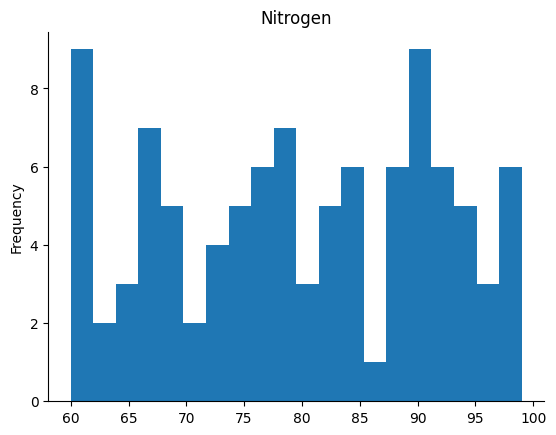

In [ ]:
# @title Nitrogen

from matplotlib import pyplot as plt
crop_data['Nitrogen'].plot(kind='hist', bins=20, title='Nitrogen')
plt.gca().spines[['top', 'right',]].set_visible(False)

# Performing One-Hot Encoding on This

## Splitting into X and Y

<Axes: >

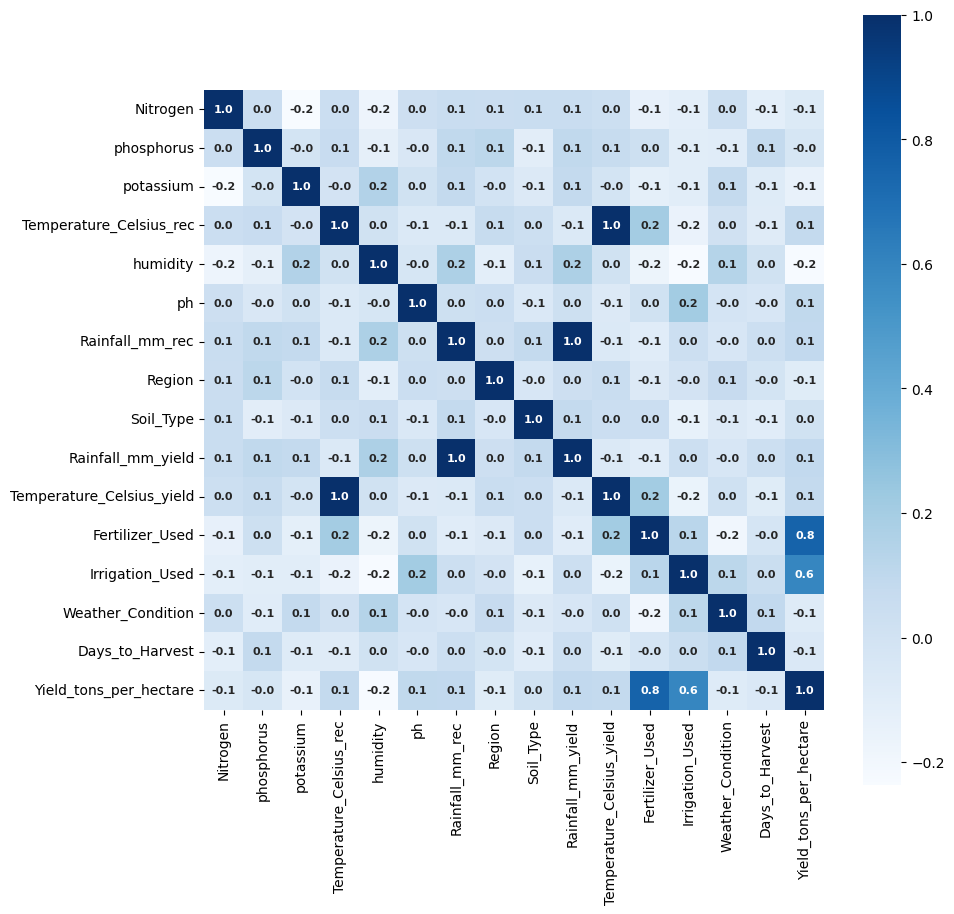

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(correlation,cbar=True,square=True,fmt='.1f',annot=True,annot_kws={'size':8, 'fontweight': 'bold'},cmap ='Blues')

In [ ]:
X_features = list(crop_data.columns)
X_features.remove("Yield_tons_per_hectare")
# Performing One hot encoding.
encoded_crop_df = pd.get_dummies(crop_data[X_features], drop_first=True)

In [ ]:
X = encoded_crop_df
#Less than or equal to 3 is bad and greater than 3 is good.
Y = crop_data['Yield_tons_per_hectare'].apply(lambda y_value: 1 if y_value >= 3.5 else 0)

In [ ]:
#Splitting into training data and test data.
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=2)

In [ ]:
#Training model using Linear Regression first
model = RandomForestClassifier(max_depth=15, max_features="sqrt", n_estimators=20)
model.fit(X_train, Y_train)

RandomForestClassifier(max_depth=15, n_estimators=20)

In [ ]:
#get the AUC score
predict_proba_df = pd.DataFrame( model.predict_proba(  X_test))

test_results_df = pd.DataFrame({'actual': Y_test})
test_results_df = test_results_df.reset_index()
test_results_df['chd_1'] = predict_proba_df.iloc[:, 1:2]
test_results_df.head()

,index,actual,chd_1
0,83,0,0.30
1,30,0,0.10
2,56,0,0.15
3,24,0,0.10
4,16,1,0.70


In [ ]:
from sklearn.metrics import roc_auc_score

auc_score = roc_auc_score(test_results_df.actual, test_results_df.chd_1)
round( float(auc_score), 2)

0.99

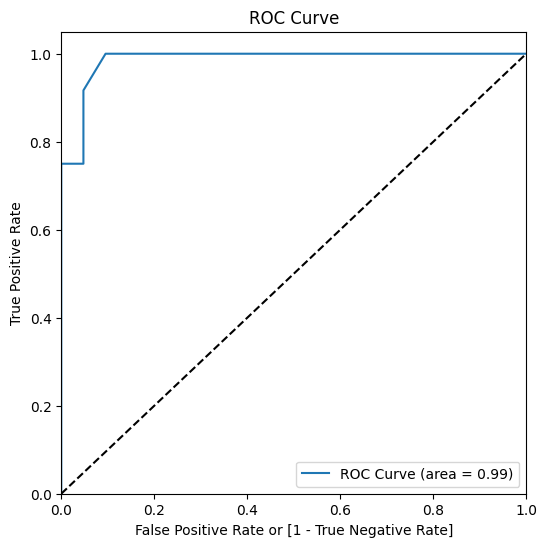

In [ ]:
from sklearn.metrics import roc_curve

def draw_roc_curve(model, X_test, Y_test):
  fpr, tpr, thresholds = roc_curve(test_results_df.actual, test_results_df.chd_1, drop_intermediate= False)
  plt.figure(figsize=(6,6))
  plt.plot(fpr, tpr, label = "ROC Curve (area = %0.2f)" % auc_score)
  #Plot the diagonal line
  plt.plot([0,1],[0,1],'k--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
  plt.ylabel('True Positive Rate')
  plt.title("ROC Curve")
  plt.legend(loc = "lower right")
  plt.show()

  return fpr, tpr, thresholds

_, _, _ = draw_roc_curve(model, X_test, Y_test)

In [ ]:
#Evaluation of the model
#Training the model on the training data

y_pred = model.predict(X_test)
test_data_accuracy = accuracy_score(Y_test, y_pred)
print('Accuracy for test data is: ', test_data_accuracy*100)

Accuracy for test data is:  87.87878787878788


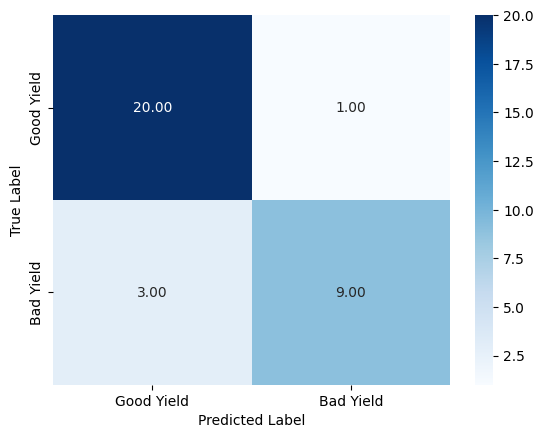

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

conf = confusion_matrix(Y_test, y_pred)
sn.heatmap(conf, annot=True, cmap='Blues', fmt='.2f',
           xticklabels=["Good Yield", "Bad Yield"],
           yticklabels=["Good Yield",  "Bad Yield"])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV

tuned_parameters = [{'max_depth': [10, 15],
                     'n_estimators': [10, 20],
                     'max_features' : ['sqrt', 0.2] }]

clf = GridSearchCV(model, tuned_parameters, cv = 5, scoring = 'roc_auc')

clf.fit(X_train, Y_train)
clf.best_score_
clf.best_params_

{'max_depth': 15, 'max_features': 0.2, 'n_estimators': 20}